In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point
from sklearn.neighbors import BallTree
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import gradient_boost_regressor as gb

import warnings

warnings.filterwarnings("ignore")

In [2]:
def clean_data(data):
    cleaned_data = data
    # cleaned_data = cleaned_data.drop_duplicates(subset=None, keep='first', inplace=False)
    cleaned_data = cleaned_data.drop(columns=['furnished', 'elevation'])
    cleaned_data['flat_type'] = cleaned_data['flat_type'].str.replace(r'(2|3|4|5)-room|(\d) room', r'\1\2', regex=True)
    cleaned_data['flat_type'] = cleaned_data['flat_type'].str.replace('executive', '6')
    cleaned_data['flat_type'] = cleaned_data['flat_type'].astype(int)
    cleaned_data['rent_approval_date'] = cleaned_data['rent_approval_date'].str[2:].str.replace('-', '', regex=False)
    cleaned_data['rent_approval_date'] = cleaned_data['rent_approval_date'].astype(int)
    
    return cleaned_data

In [3]:
def get_stock_data(average_monthly_data ,stock_name, year, month):
    return average_monthly_data.loc[(stock_name, year, month)]

def chunk(nameslist):
    for i in range(0, len(nameslist), 10):
        yield nameslist[i:i+10]

def normalize(group):
    min_val = group.min()
    max_val = group.max()
    group = (group - min_val) / (max_val - min_val)
    return group

def add_stock_data(org_dataset, is_test=False):
    stockdata = pd.read_csv("auxiliary-data/sg-stock-prices.csv")

    stockdata['date'] = pd.to_datetime(stockdata['date'])
    stockdata['year'], stockdata['month'] = stockdata['date'].dt.year, stockdata['date'].dt.month
    average_monthly_data = stockdata.groupby(['name', 'year', 'month']).mean(numeric_only=True).reset_index()

    names = list(set(stockdata['name']))

    average_monthly_data['normalized_value'] = average_monthly_data.groupby('name')['adjusted_close'].transform(normalize)

    stockdata_pivot = average_monthly_data.pivot_table(index=['year', 'month'], columns='name', values='adjusted_close').reset_index()
    stockdata_pivot['year'] = stockdata_pivot['year'].astype(int)
    stockdata_pivot['month'] = stockdata_pivot['month'].astype(int)

    org_dataset[['year', 'month']] = org_dataset['rent_approval_date'].str.split('-', expand=True)
    org_dataset['year'] = org_dataset['year'].astype(int)
    org_dataset['month'] = org_dataset['month'].astype(int)

    merged = pd.merge(org_dataset, stockdata_pivot, on=['year', 'month'], how='left')

    # Use interpolation to fill NaN values for each stock column
    for stock in average_monthly_data['name'].unique():
        merged[stock] = merged[stock].interpolate(method='nearest').ffill().bfill()

    # allcornames = names
    # allcornames = allcornames + ['monthly_rent']

    # print("XXXXXXXXXXXXXXXXXXX\n", allcornames)
    
    # for name in allcornames:
    #     if name not in merged.columns:
    #         print(f"'{name}' not found in the merged DataFrame columns.")

    
    # cor1 = merged[allcornames].corr()


    # df = pd.DataFrame(cor1)
    # temp_cols=df.columns.tolist()
    # new_cols=temp_cols[-1:] + temp_cols[:-1]
    # df=df[new_cols]

    # pos_corr_stocks = []
    # neg_corr_stocks = []

    # for row, value in df['monthly_rent'].items():
    #     if row=='monthly_rent':
    #         continue
    #     elif value > 0.35:
    #         pos_corr_stocks.append(row)
    #     elif value < -0.35:
    #         neg_corr_stocks.append(row)

    # allcornames.pop(-1)

    # chunked = list(chunk(nameslist))

    pos_corr_stocks = ['Keppel',
    'Flex',
    'Jardine Cycle & Carriage',
    'Singapore Airlines',
    'Golden Agri-Resources',
    'OCBC Bank',
    'Genting Singapore',
    'DBS Group',
    'Singtel',
    'Sembcorp',
    'UOB']

    neg_corr_stocks = ['Great Eastern',
    'SATS',
    'Sea (Garena)',
    'Mapletree Industrial Trust',
    'Mapletree Commercial Trust',
    'Singapore Post',
    'Grab Holdings',
    'Yanlord',
    'Singapore Land',
    'Karooooo',
    'Riverstone Holdings',
    'ComfortDelGro',
    'IGG Inc',
    'Triterras',
    'Keppel REIT',
    'ASLAN Pharmaceuticals']

    merged['average_stock_value'] = merged[names].mean(axis=1)
    merged['highest_pos_corr'] = merged[pos_corr_stocks].mean(axis=1)
    merged['highest_neg_corr'] = merged[neg_corr_stocks].mean(axis=1)
    merged = merged.drop(names, axis=1)
    merged = merged.drop(['year', 'month'], axis=1)
    return merged

In [4]:
X = pd.read_csv('train.csv')
X = add_stock_data(X)
X = clean_data(X)
X = gb.add_aux_data(X)
X.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,...,average_stock_value,highest_pos_corr,highest_neg_corr,pri_schs_within_6km,gep_schs_within_5km,malls_within_3km,mrts_within_3km,nearest_distance_to_gep,nearest_distance_to_mall,nearest_distance_to_mrt
0,2109,jurong east,257,Jurong East Street 24,3,new generation,67.0,1983,1.344518,103.738630,...,16.865905,10.284115,27.300805,42,1,7,6,3753.259361,1197.254807,699.298824
1,2205,bedok,119,bedok north road,4,new generation,92.0,1978,1.330186,103.938717,...,9.817883,11.816108,9.105851,36,1,9,11,2167.360316,1114.363854,899.079717
2,2210,toa payoh,157,lorong 1 toa payoh,3,improved,67.0,1971,1.332242,103.845643,...,8.741430,12.308259,7.141971,45,5,13,20,1897.242758,468.808277,218.796373
3,2108,pasir ris,250,Pasir Ris Street 21,6,apartment,149.0,1993,1.370239,103.962894,...,13.638755,10.367904,25.943085,25,1,6,4,3753.937855,400.744149,1547.364292
4,2211,kallang/whampoa,34,Whampoa West,3,improved,68.0,1972,1.320502,103.863341,...,9.056997,12.918036,7.076766,45,3,22,26,3095.238252,1067.395062,187.932631


In [5]:
X.nunique()

rent_approval_date            31
town                          26
block                       2553
street_name                 1083
flat_type                      5
flat_model                    19
floor_area_sqm               146
lease_commence_date           54
latitude                    8612
longitude                   8590
subzone                      152
planning_area                 29
region                         5
monthly_rent                 113
average_stock_value         6228
highest_pos_corr              31
highest_neg_corr             112
pri_schs_within_6km           61
gep_schs_within_5km            7
malls_within_3km              55
mrts_within_3km               49
nearest_distance_to_gep     8612
nearest_distance_to_mall    8612
nearest_distance_to_mrt     8612
dtype: int64

In [6]:
X.dtypes

rent_approval_date            int64
town                         object
block                        object
street_name                  object
flat_type                     int64
flat_model                   object
floor_area_sqm              float64
lease_commence_date           int64
latitude                    float64
longitude                   float64
subzone                      object
planning_area                object
region                       object
monthly_rent                  int64
average_stock_value         float64
highest_pos_corr            float64
highest_neg_corr            float64
pri_schs_within_6km           int64
gep_schs_within_5km           int64
malls_within_3km              int64
mrts_within_3km               int64
nearest_distance_to_gep     float64
nearest_distance_to_mall    float64
nearest_distance_to_mrt     float64
dtype: object

In [7]:
X_train = X.copy()


In [8]:
categorical = ['flat_model', 'subzone', 'region', 'planning_area', 'town', 'block', 'street_name']

In [9]:
for cat in categorical:
    X_train[cat] = pd.factorize(X_train[cat])[0]


In [10]:
corr_matrix = X_train.corrwith(X_train['monthly_rent'])
corr_matrix.sort_values()

highest_neg_corr           -0.463779
average_stock_value        -0.428084
latitude                   -0.116359
nearest_distance_to_mall   -0.071179
nearest_distance_to_gep    -0.068452
nearest_distance_to_mrt    -0.067172
pri_schs_within_6km        -0.065586
region                     -0.031655
longitude                  -0.003458
street_name                 0.050470
planning_area               0.051532
town                        0.051559
subzone                     0.056608
block                       0.073598
flat_model                  0.098166
gep_schs_within_5km         0.101557
mrts_within_3km             0.105714
malls_within_3km            0.125575
lease_commence_date         0.225966
floor_area_sqm              0.306466
flat_type                   0.321494
rent_approval_date          0.510523
highest_pos_corr            0.527923
monthly_rent                1.000000
dtype: float64

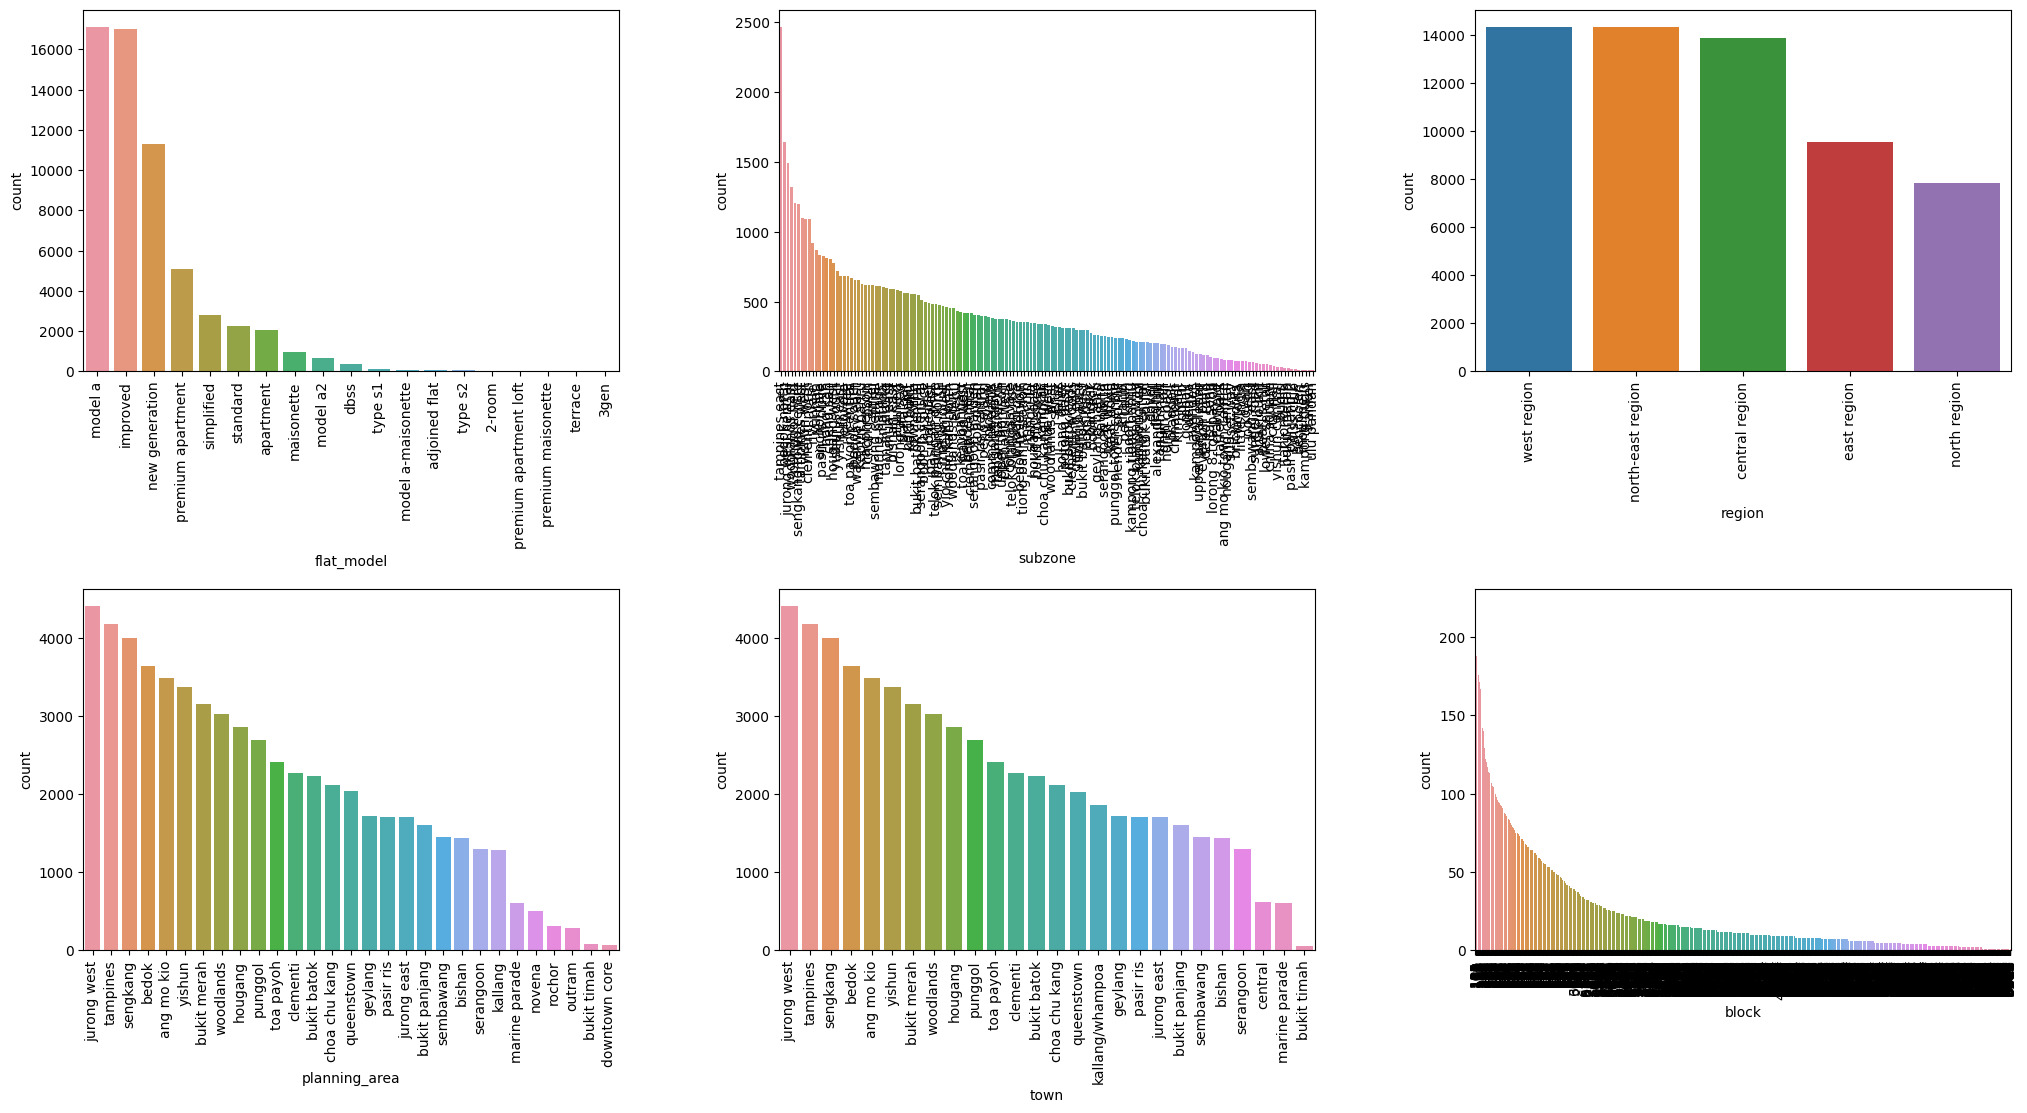

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10), squeeze=False)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.3)
for variable, subplot in zip(categorical, ax.flatten()):
    ax = sns.countplot(x = variable, ax=subplot, data=X, order=X[variable].value_counts().index)
    # ax.bar_label(ax.containers[0]) #for counts on the bars
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
plt.show()

<Axes: xlabel='floor_area_sqm', ylabel='monthly_rent'>

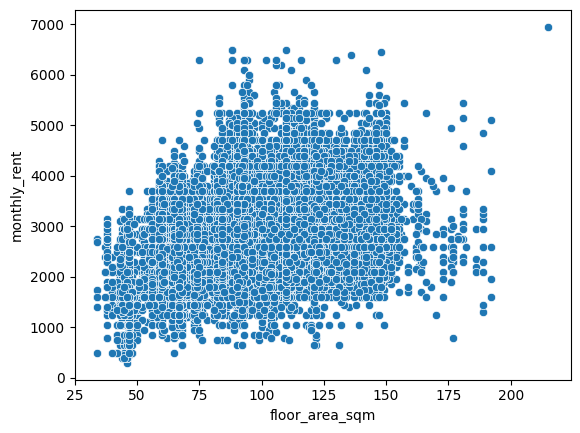

In [12]:
sns.scatterplot(x=X['floor_area_sqm'], y=X['monthly_rent'])

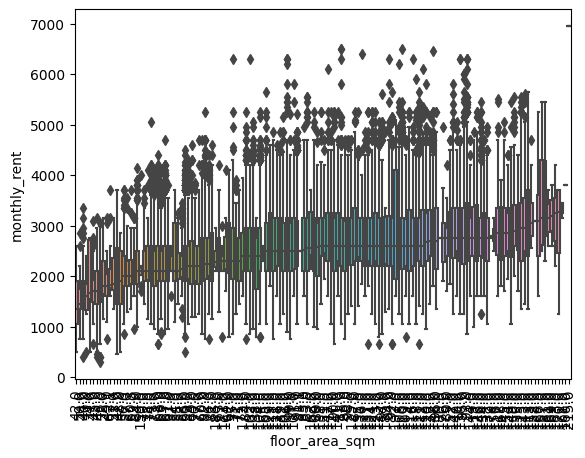

In [13]:
sorted_nb = X.groupby(['floor_area_sqm'])['monthly_rent'].median().sort_values()
sns.boxplot(x=X['floor_area_sqm'], y=X['monthly_rent'], order=list(sorted_nb.index))
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='flat_type', ylabel='monthly_rent'>

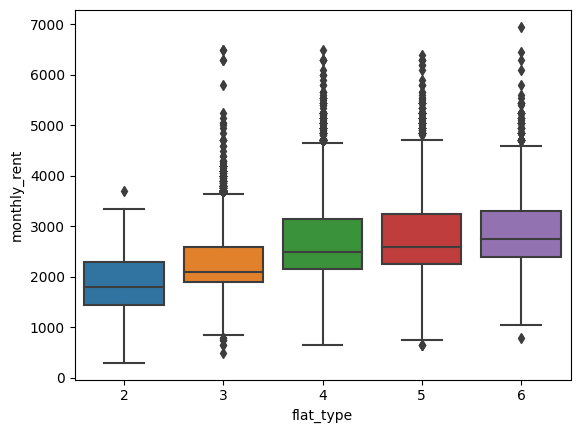

In [14]:
sns.boxplot(x=X['flat_type'], y=X['monthly_rent'])

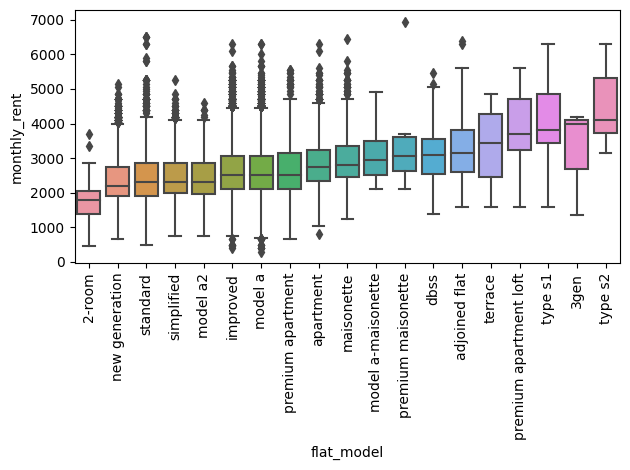

Index(['2-room', 'new generation', 'standard', 'simplified', 'model a2',
       'improved', 'model a', 'premium apartment', 'apartment', 'maisonette',
       'model a-maisonette', 'premium maisonette', 'dbss', 'adjoined flat',
       'terrace', 'premium apartment loft', 'type s1', '3gen', 'type s2'],
      dtype='object', name='flat_model')


In [20]:
sorted_nb = X.groupby(['flat_model'])['monthly_rent'].median().sort_values()
sns.boxplot(x=X['flat_model'], y=X['monthly_rent'], order=list(sorted_nb.index))
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("figures/flat_model_order.png")
plt.show()
print(sorted_nb.keys())

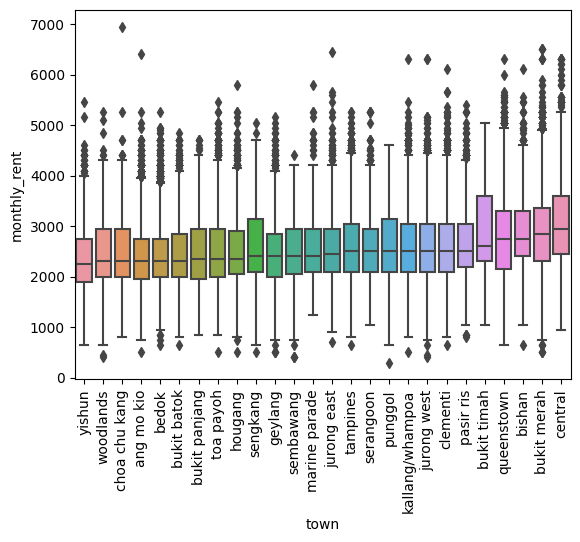

In [11]:
sorted_nb = X.groupby(['town'])['monthly_rent'].median().sort_values()
sns.boxplot(x=X['town'], y=X['monthly_rent'], order=list(sorted_nb.index))
plt.xticks(rotation=90)
plt.show()

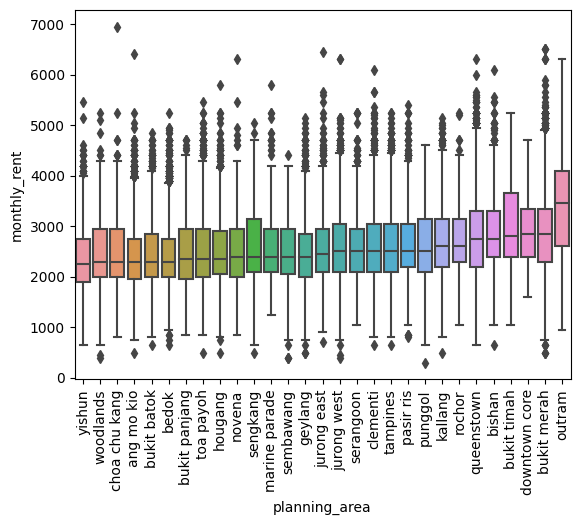

In [12]:
sorted_nb = X.groupby(['planning_area'])['monthly_rent'].median().sort_values()
sns.boxplot(x=X['planning_area'], y=X['monthly_rent'], order=list(sorted_nb.index))
plt.xticks(rotation=90)
plt.show()

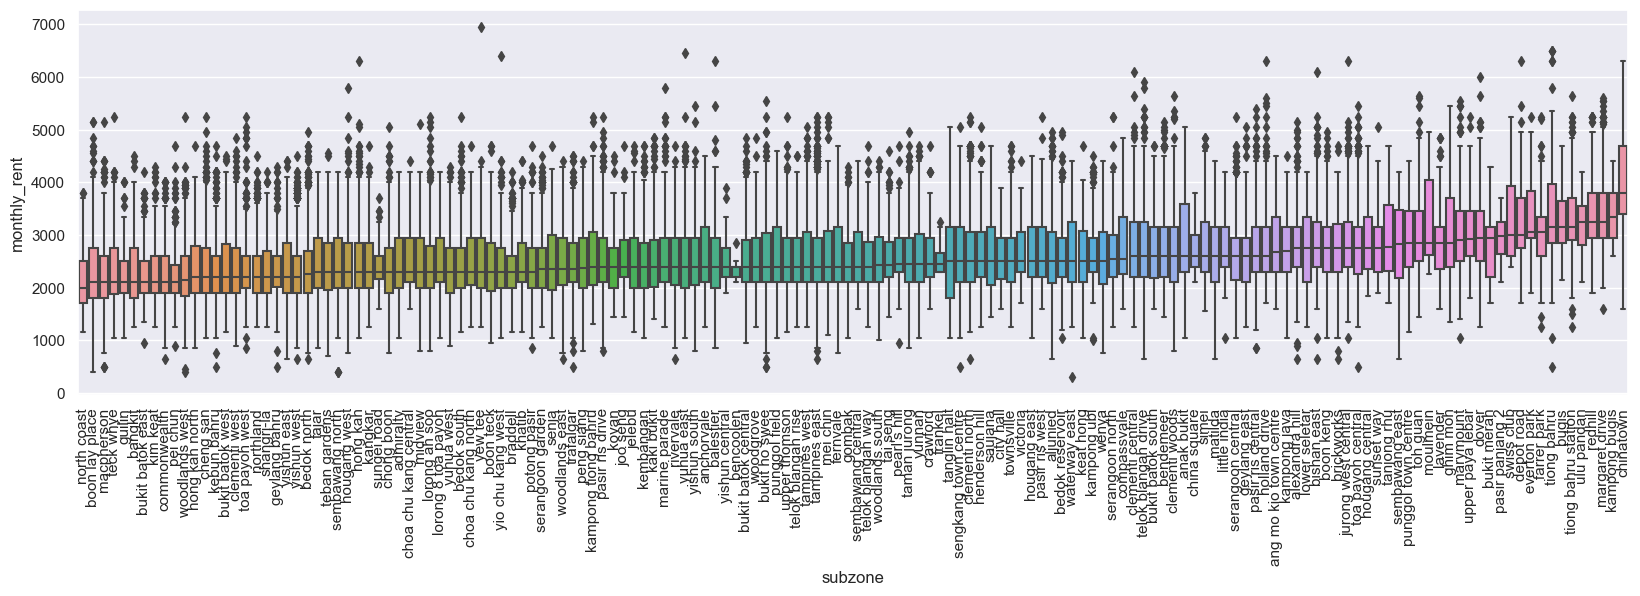

In [13]:
sorted_nb = X.groupby(['subzone'])['monthly_rent'].median().sort_values()
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(x=X['subzone'], y=X['monthly_rent'], order=list(sorted_nb.index))
plt.xticks(rotation=90)
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/79/pfv4jyfs1rgbw0rk8frd3nc40000gn/T/ipykernel_39463/1956789067.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


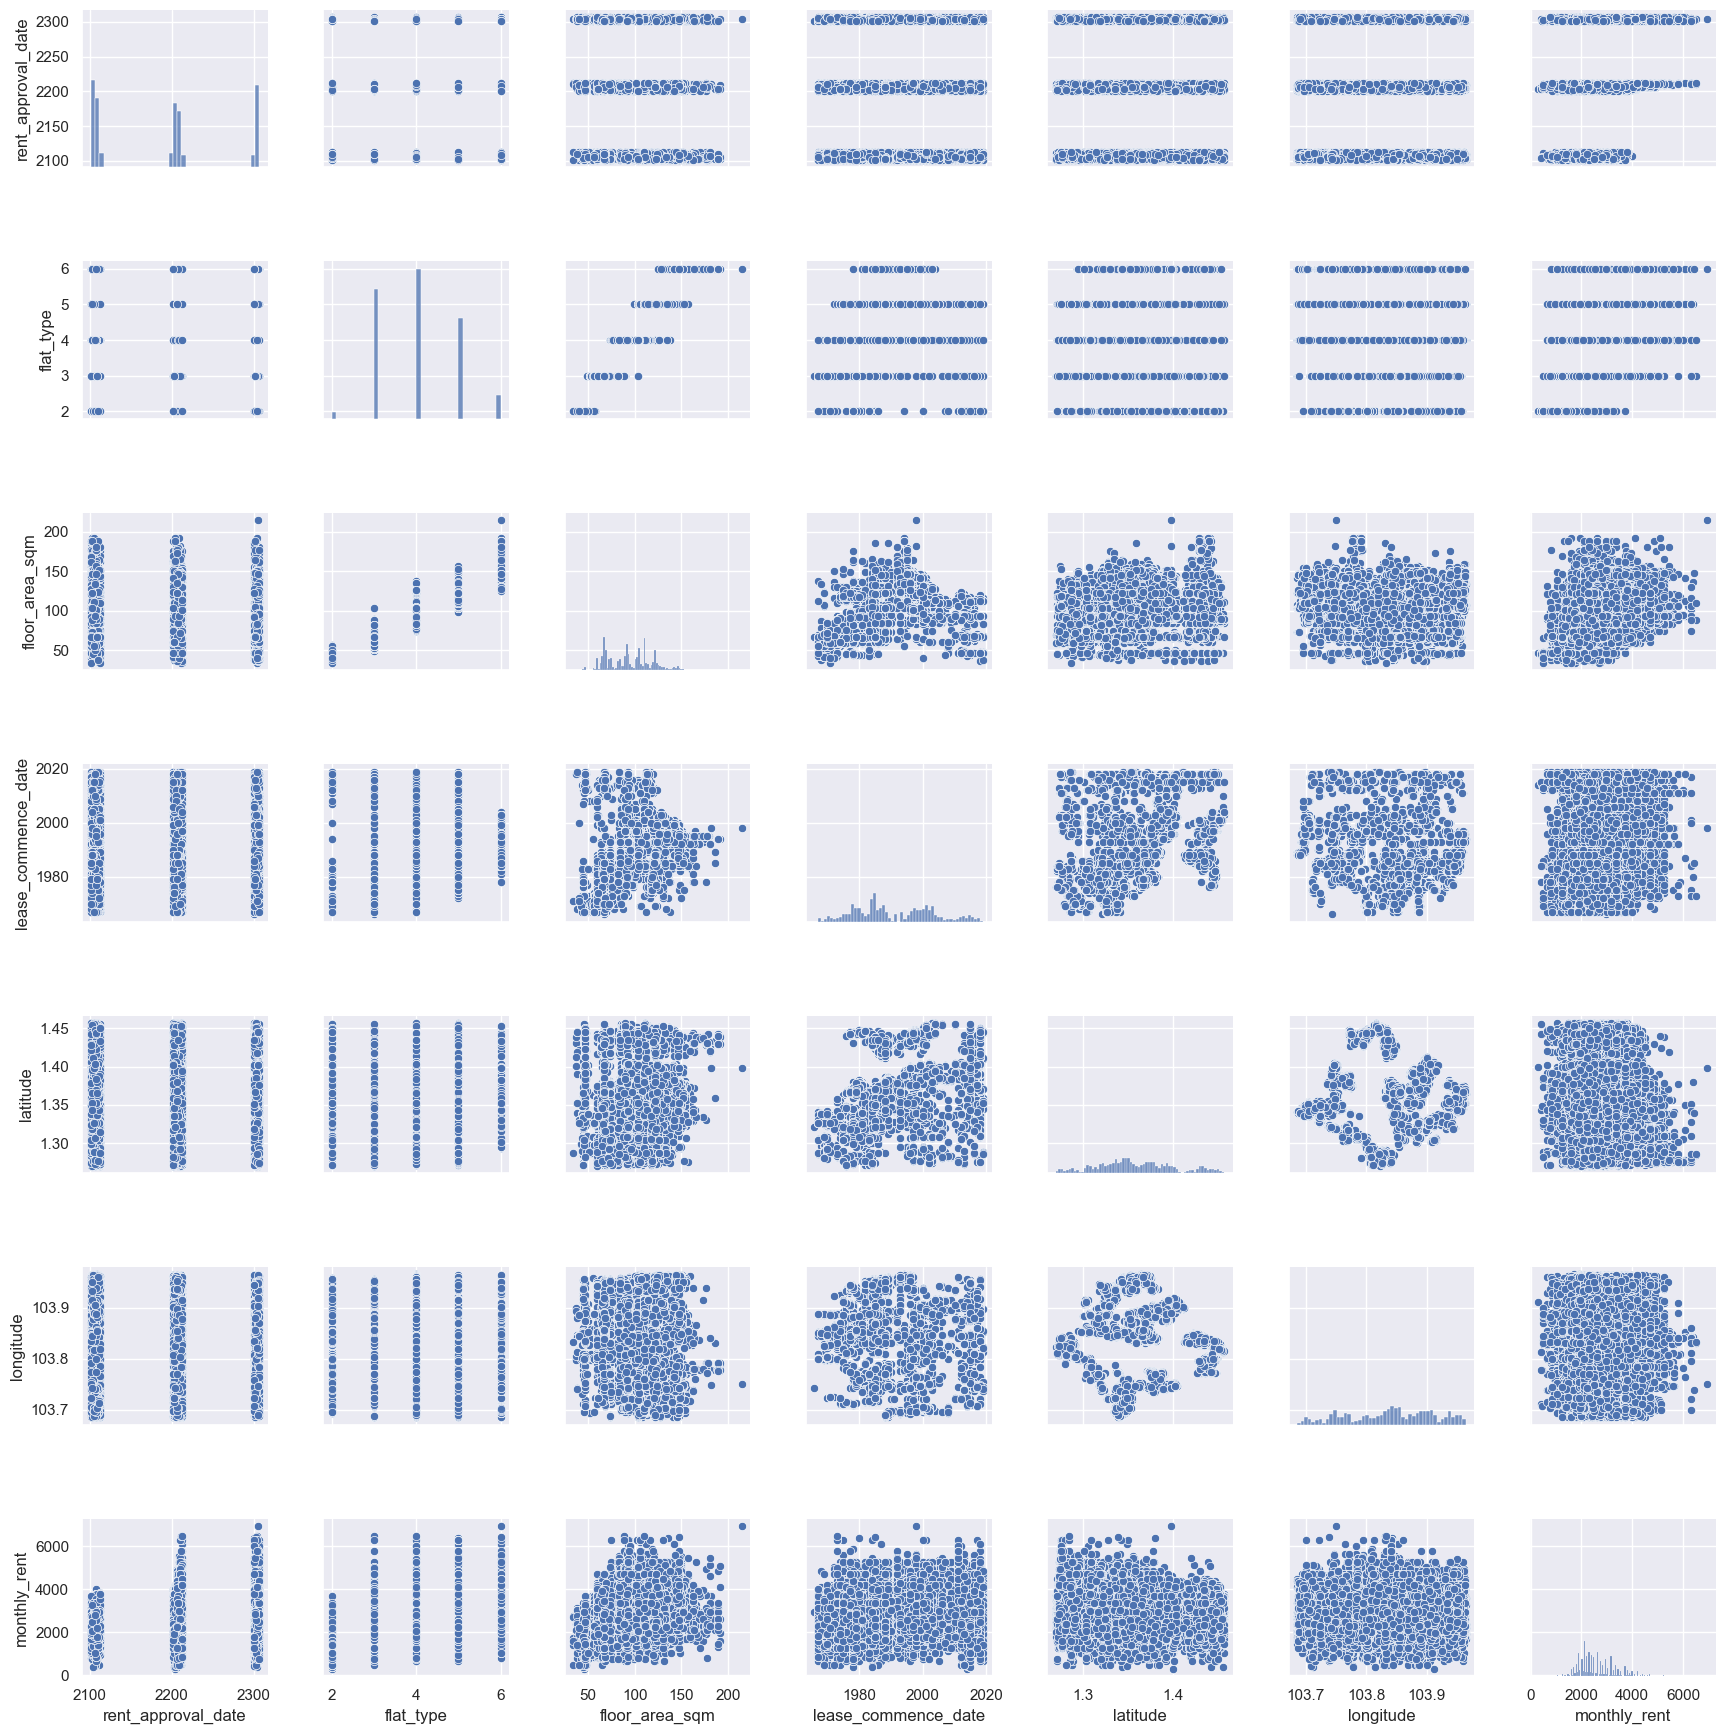

In [20]:
sns.pairplot(X)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6, wspace=0.3)
plt.show()

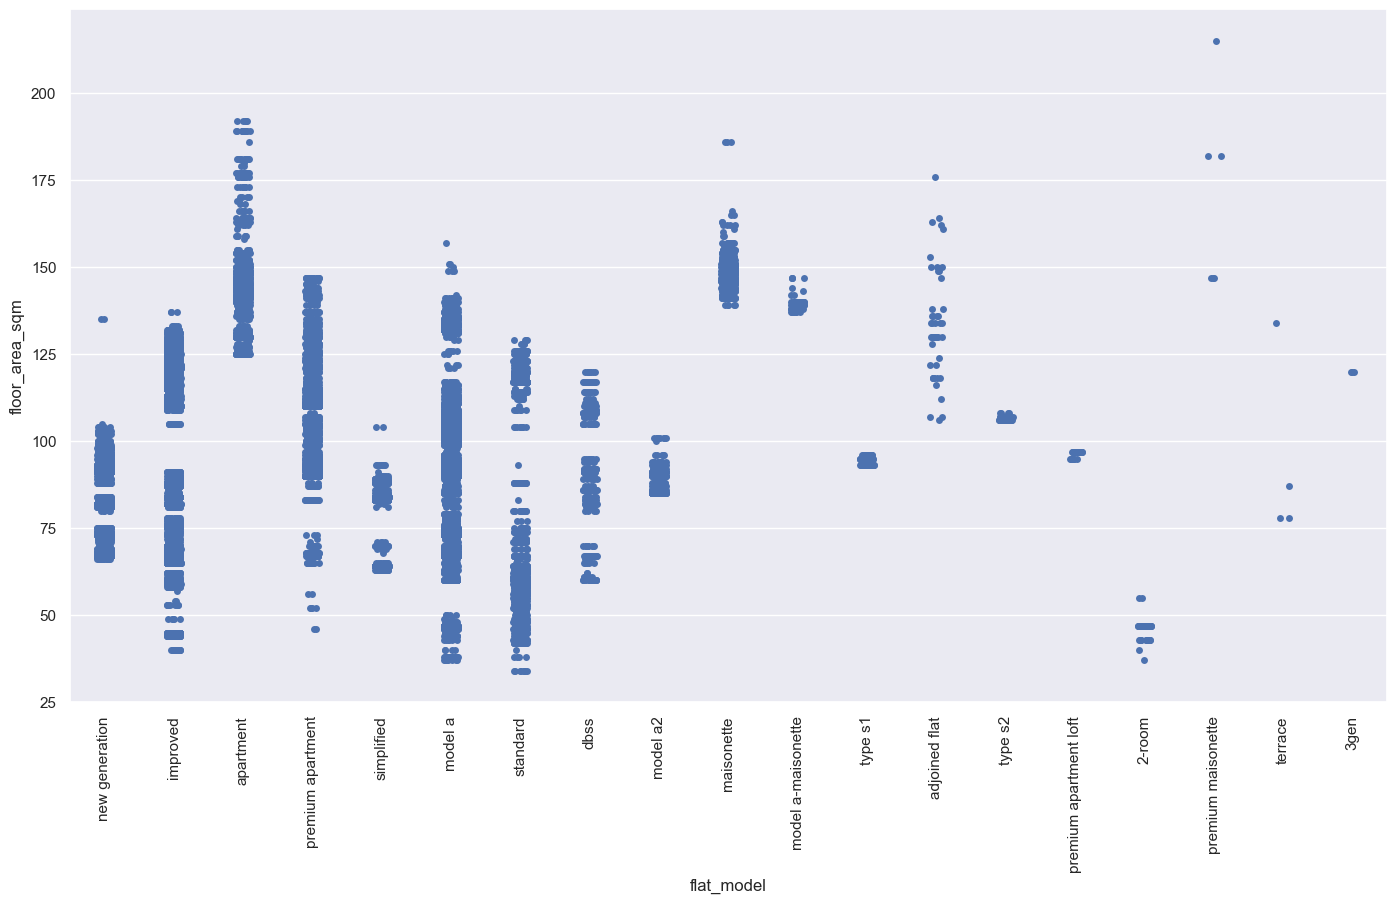

In [24]:
plt.figure(figsize=(17,9))
sns.stripplot(x="flat_model", y="floor_area_sqm", data=X)
plt.xticks(rotation=90)
plt.show()

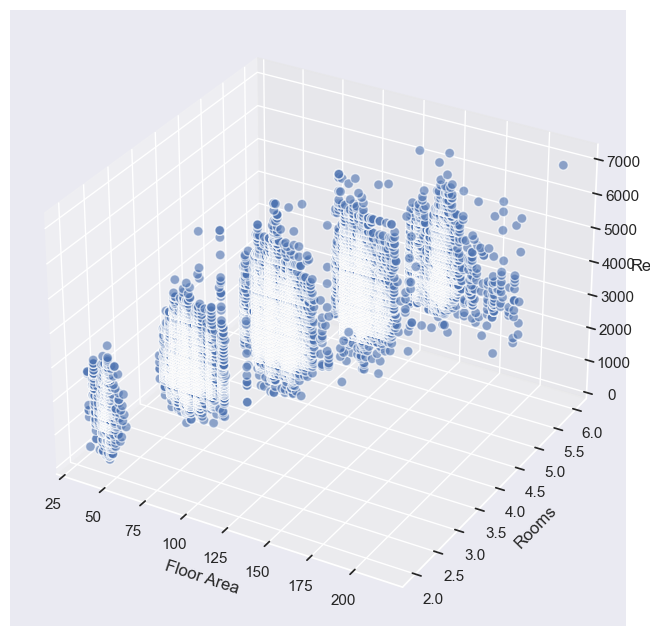

In [28]:
# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection = '3d')

xv = X['floor_area_sqm']
yv = X['flat_type']
zv = X['monthly_rent']
ax.scatter(xv, yv, zv, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('Floor Area')
ax.set_ylabel('Rooms')
ax.set_zlabel('Rent')
plt.show()